<a href="https://colab.research.google.com/github/agarr3/BertLong/blob/master/WI_CLASSIFIER_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#settings
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

criterion = nn.CrossEntropyLoss()

n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/"


seq_len=200

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
# DATA_SONG_DIR = "48Bins"
# DATA_IMG_DIR = "48Bins"
# input_bins = 48

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
# DATA_SONG_DIR = "Activations_64"
# DATA_IMG_DIR = "Activations_64"
# input_bins = 64

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
# DATA_SONG_DIR = "Activations_128"
# DATA_IMG_DIR = "Activations_128"
# input_bins = 128

DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
DATA_SONG_DIR = "reconstructions"
DATA_IMG_DIR = "reconstructions"
input_bins = 48

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# DATA_BASE_PATH = "/content/gdrive/"
# DATA_SONG_DIR = "My Drive"
# DATA_IMG_DIR = "My Drive"

# files = []
# exclusion = ["098567.npy","098569.npy", '098565.npy']
# for r,d, fileList in os.walk("/content/gdrive/My Drive/Western_numpy"):
#   for file in fileList:
#     if(file not in exclusion):
#       files.append([file,file, "Western_numpy"])
#     else:
#       print(file)

# random.seed(1234)
# files = random.sample(files, 2008)

# for r,d, fileList in os.walk("/content/gdrive/My Drive/Indian_numpy"):
#   for file in fileList:
#     if(True):
#       files.append([file,file, "Indian_numpy"])
#     else:
#       print(file)

# data = pd.DataFrame(files, columns=['Images','songs','labels'])
# #data = data.sample(frac=1).reset_index(drop=True)

# print(len(data.index))
# data.head()

print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/reconstructions/Western_numpy


,Images,songs,labels
0,987.npy,987.npy,Western_numpy
1,601.npy,601.npy,Western_numpy
2,1910.npy,1910.npy,Western_numpy
3,1247.npy,1247.npy,Western_numpy
4,1024.npy,1024.npy,Western_numpy


In [5]:
data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/reconstructions/Western_numpy/1377.npy
51.900333


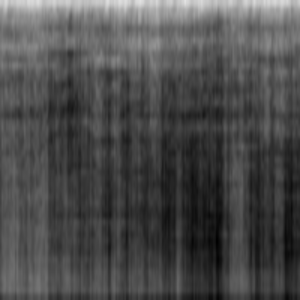

In [6]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, data.loc[test_idx, 'labels'], data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



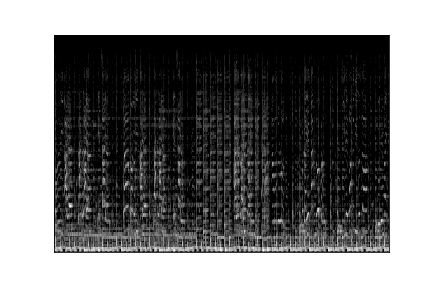

In [7]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [8]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,songs,labels,encoded_labels
0,987.npy,987.npy,Western_numpy,1
1,601.npy,601.npy,Western_numpy,1
2,1910.npy,1910.npy,Western_numpy,1
3,1247.npy,1247.npy,Western_numpy,1
4,1024.npy,1024.npy,Western_numpy,1


In [9]:
classes = ('Indian_numpy', 'Western_numpy')
data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [10]:
from sklearn.model_selection import train_test_split

data = data.sample(frac=1)
df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1406,1406
Western_numpy,1,1405,1405


In [12]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,602,602
Western_numpy,1,603,603


In [13]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [14]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        image = image[:,:seq_len]
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label



In [15]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [17]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg.squeeze()

def mel_display(S_DB):
    #print(S_DB.shape)
    S_DB = S_DB.numpy()
    array = S_DB*-1
    #print(array.max())
    array *= (255.0/array.max())
    array = 255 - array

    array = np.transpose(array, (1, 2, 0))
    return array.squeeze()

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    array = npimg*-1
    #print(array.max())
    array *= (255.0/array.max())
    array = 255 - array
    array = np.transpose(array, (1, 2, 0))
    plt.imshow(array.squeeze(), interpolation='nearest', aspect='auto')
    plt.show()

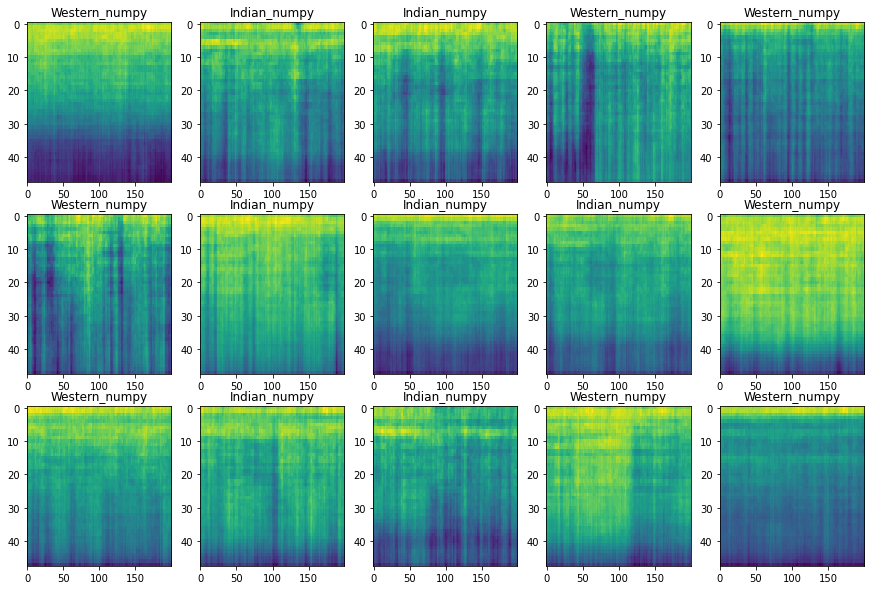

In [18]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

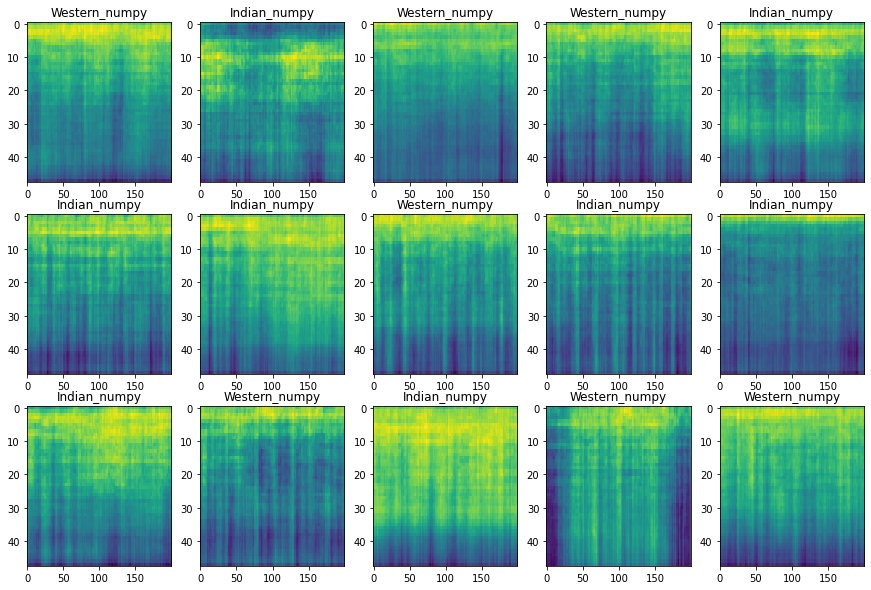

In [19]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if input_bins == 48:
          self.fc1 = nn.Linear(6768, 120)
        if input_bins == 64:
          self.fc1 = nn.Linear(9776, 120)
        if input_bins == 128:
          self.fc1 = nn.Linear(6768, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6768, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [21]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('Accuracy of the network on the train images after epoch {} is {}'.format(epoch, 100 * correct / total) )
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
        
        
    

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,     1] loss: 0.695
[1,     2] loss: 0.716
[1,     3] loss: 0.719
[1,     4] loss: 0.694
[1,     5] loss: 0.695
[1,     6] loss: 0.690
[1,     7] loss: 0.691
[1,     8] loss: 0.696
[1,     9] loss: 0.720
[1,    10] loss: 0.681
[1,    11] loss: 0.690
[1,    12] loss: 0.694
[1,    13] loss: 0.688
[1,    14] loss: 0.697
[1,    15] loss: 0.684
[1,    16] loss: 0.688
[1,    17] loss: 0.687
[1,    18] loss: 0.683
[1,    19] loss: 0.688
[1,    20] loss: 0.685
[1,    21] loss: 0.691
[1,    22] loss: 0.678
Accuracy of the network on the train images after epoch 0 is 50.622554251156174
Accuracy of the network on the test images: 54 %
[2,     1] loss: 0.680
[2,     2] loss: 0.692
[2,     3] loss: 0.700
[2,     4] loss: 0.681
[2,     5] loss: 0.675
[2,     6] loss: 0.671
[2,     7] loss: 0.672
[2,     8] loss: 0.675
[2,     9] loss: 0.689
[2,    10] loss: 0.665
[2,    11] loss: 0.677
[2,    12] loss: 0.680
[2,    13] loss: 0.667
[2,    14] loss: 0.691
[2,    15] loss: 0.676
[2,    16] loss: 0.6

Accuracy for class Indian_numpy is: 61.1 %
Accuracy for class Western_numpy is: 83.4 %


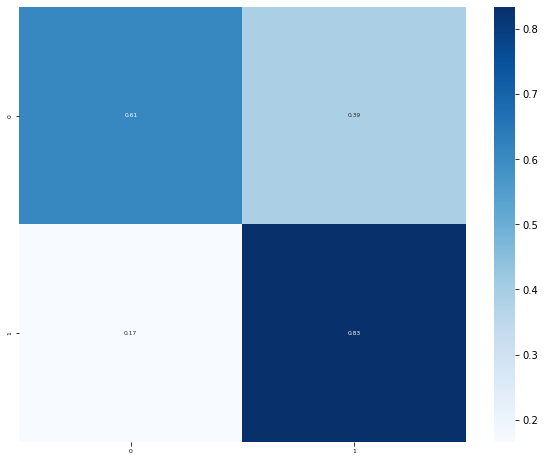

In [23]:
import seaborn as sns
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 6},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

Accuracy for class Indian_numpy is: 70.8 %
Accuracy for class Western_numpy is: 89.3 %


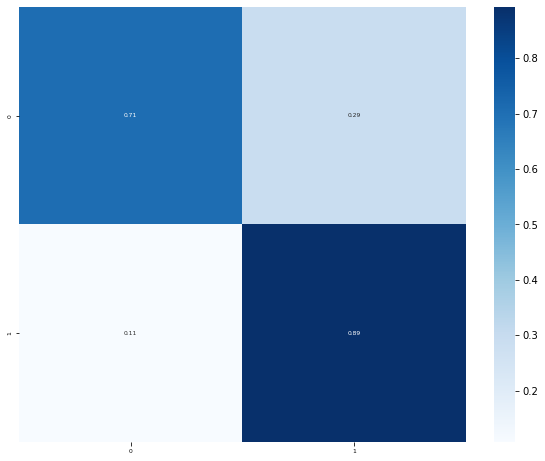

In [24]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)

# again no gradients needed
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 6},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [27]:
classes

('Indian_numpy', 'Western_numpy')